# Information Processing for Medical Imaging 
# MPHY0025 - 2018/2011
## Registration workshop 3, 31st January 2019
## Python version

#### Colab set-up
[Open in Colab](https://colab.research.google.com/github/meganzoe/ipmi-registration/blob/master/workshop_3/registration_workshop_3.ipynb)

Uncomment all of the lines below to clone the code into the virtual Colab workspace. We need scikit-image version 0.14 for the demons algorithm to run.

In [1]:
#!git clone https://github.com/meganzoe/ipmi-registration
#import os
#os.chdir('ipmi-registration/workshop_3')
#!pip install scikit-image --upgrade

## Diffeomorphic Demons

You have been provided with a new version of the Python class for running the demons registration within the script `demonsV2.py`, as well as a new function, `dispDefField` within `utils.py`. The new script is the same as the one from last week, but uses the new function to display the current deformation field and update to the deformation field either as a deformed grid or a ‘vector field’ (i.e. small arrows). Examples of these are shown below (left: deformation field shown as a grid; right: update vector field). If you look at the new `demonsV2.py` script you will see 4 new parameters (within the class initilisation `__init__`) that can be set using an _options dictionary_ which control how the deformation field and update are displayed: 
- `disp_spacing`
- `scale_update_for_display`
- `disp_method_df`
- `disp_method_up`

(-0.5, 1191.5, 544.5, -0.5)

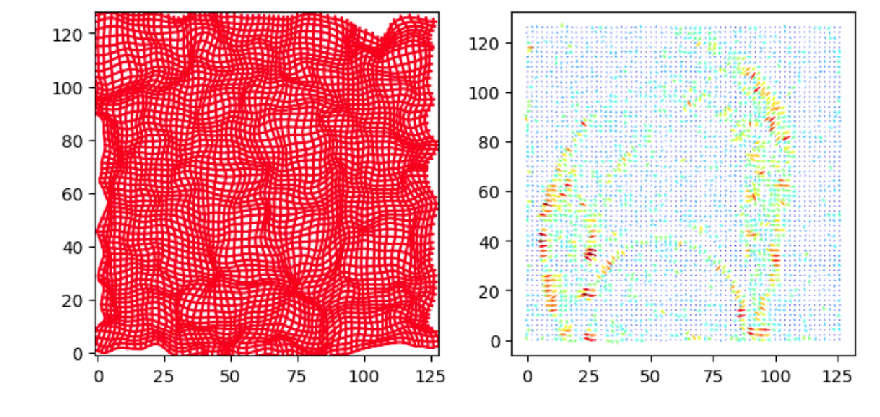

In [4]:
from skimage import io
import numpy as np
img = io.imread('figure1.PNG')
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.imshow(img)
plt.axis('off')

Load in the images stored in `cine_MR_1.png` and `cine_MR_2.png` that were provided for the exercises last week (remembering to convert them to doubles and re-orientate them into the ‘standard orientation’), and then run the new `DemonsAlgorithm` within `demonsV2.py` by:
```python
from demonsV2 import DemonsAlgorithm
optDict = {}
optDict['target'] = cine_MR_1
optDict['source'] = cine_MR_2
optDict['disp_freq'] = 10
optDict['sigma_elastic'] = 0.5
optDict['sigma_fluid'] = 1

# initialise the algorithm with the chosen options
d = DemonsAlgorithm(optDict)
# run the algorithm
d.run()
# to extract the final deformation field from the algorithm
# use d.def_field after you have run the algorithm
final_def_field = d.def_field
```
The `optDict` is a Python dictionary of options that can be passed to the DemonsAlgorithm. If you take a look at `demonsV2.py` you will see that within the initilisation `__init__` of the class there are many options for the algorithm that can be set like the above. The default values are set using the `optDict.get()` function within `__init__`. To change the default parameters, you can overwrite the options by passing the `optDict` to the algorithm like the above.  

The deformation field and update are now displayed during each displayed iteraton. _Note: you can view the full output of the cell by clicking the white box to the left of the cell output_.

In the provided script the deformation field is displayed as a deformed grid whereas the update is displayed using a vector field, but this behaviour can be modified using the new parameters mentioned above. Try modifying the new parameters and see how the displays are affected. E.g.:
```python
optDict['disp_method_df'] = 'arrows'
optDict['disp_method_up'] = 'grid'

d2 = demonsAlgorithm(optDict)
d2.run()
```

When you run the registration using the parameters in the provided script, i.e.:
```python
optDict['sigma_elastic'] = 0.5
optDict['sigma_fluid'] = 1
optDict['num_lev'] = 3
```
you should notice that the registration appears to align the images very well. However, if you look closely at the deformation field you will see that folding has occurred in some places.

You have also been provided with a function within `utils.py` to calculate the Jacobian determinant and the full Jacobian matrix for each pixel in the deformation field, `calcJacobian`. Have a look at this function and make sure you understand how it works. If you run the following lines of code:
```python 
import utils
# retrieve the final deformation field from the last run 
# demons algorithm
def_field = d2.def_field
# calculate the Jacobian
J, J_Mat = utils.calcJacobian(def_field)
# sum the values less than or equal to zero
print(np.sum(np.less_equal(J,0))
```

You will see that there are a few hundred pixels that have a Jacobian determinant less than or equal to 0, indicating that folding has occurred in those pixels. 

You can also display the map of Jacobian determinants as an image (e.g. using the  `utils.dispImage` function so that it is displayed in the same orientation as the images). You will notice that there are some large values (> 3.5) as well as values < 0, and that the map is very patchy, and does not show smooth expansions/contractions as would be expected during breathing.

An example is shown below:


(-0.5, 450.5, 386.5, -0.5)

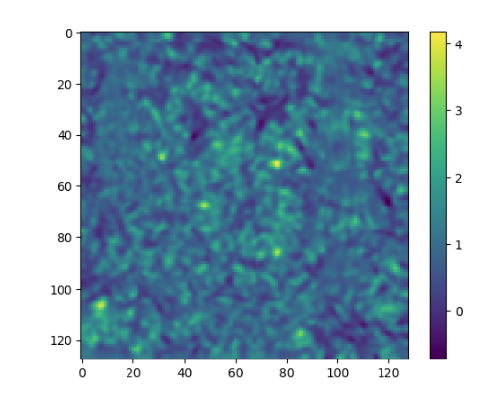

In [7]:
from skimage import io
import numpy as np
img = io.imread('figure2.PNG')
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
plt.imshow(img)
plt.axis('off')

Plotted using:
```python
import matplotlib.pyplot as plt
plt.imshow(J.T)
plt.colorbar()
```

# Diffeomorphic Demons
We are now going to modify the `DemonsAlgorithm` class to compose the updates rather than add them, so that the deformation field will always represent a diffeomorphic transformation (as the updates are themselves diffeomorphic), and hence will not contain any folding.

To compose the update, we need to calculate:

$$T_{comp}(x) = T_{current}(T_{update}(x))$$
        
The update is stored as a displacement field, $\mathbf{u}_{disp}$, so first we need to convert this to a deformation field, $\mathbf{u}_{def}$, by adding the pixel coordinates, i.e.:

$$ T_{update}(x) = \mathbf{u}_{def}(x) = \mathbf{u}_{disp}(x) + x $$

$T_{comp}(x)$ can then be calculated by resampling $T_{current}$ using the update deformation field, $\mathbf{u}_{def}$, in the same way was an image would be resampled using $\mathbf{u}_{def}$, i.e.:

$$ I_{resamp}(x) = I_{orig}(T_{update}(x)) = I_{orig}(\mathbf{u}_{def}(x))$$

### To modify the demons algorithm:
- If you are working locally, you can make a copy of `demonsV2.py` and modify the copied script. 
- If you are working via Colab, you are going to have to copy the contents of `demonsV2.py` into a cell below to make the modifications. 


1. **Delete** (or comment out) the lines of code which add the update:
   ```python
            disp_field_x = disp_field_x + update_x
            disp_field_y = disp_field_y + update_y
    ```
2. Form a deformatin field from the displacements stored in the update variables. An empty variable needs to be created first (to avoid errors when re-running multi-resolution):
   ```python
            up_def_field = np.zeros_like(disp_field_x)
   ```
   Then the pixel coordinates, stored in `X` and `Y`, need to be added to the updates and stored in a single 3D array (as used for the current deformation field):
   ```python
            up_def_field[:,:,0] = update_x + X
            up_def_field[:,:,1] = update_y + Y
   ```
3. Calculate the composed deformation field by resampling the current deformation field using the update deformation field. Note, the `x` and `y` components of the current deformation field must be resampled separately:
    ```python
            def_field[:,:,0] = utils.resampImageWithDefField(def_field[:,:,0], up_def_field)
            def_field[:,:,1] = utils.resampImageWithDefField(def_field[:,:,1], up_def_field)
    ```
4. Recalculate the displacement field variables from the composed deformation (as the displacement field, rather than the deformation field, is smoothed when applying elastic regularisation):
```python
            disp_field_x = def_field[:,:,0] - X
            disp_field_y = def_field[:,:,1] - Y
```
5. When the deformation field was resampled, pixels outside the original deformation field were given a value of NaN. These need to be replaced in the deformation field with values of 0 (note, they do not need replacing in the deformation field, as the deformation field values are recalculated from the displacement field after the elastic regularisation is applied):
```python
            disp_field_x[np.isnan(disp_field_x)] = 0
            disp_field_y[np.isnan(disp_field_y)] = 0
```
6. Now save your modified script (or function), e.g. as `diffeoDemonsScript.py` if you are working locally. 


If you have followed the steps above correctly when you run your new Demons Algorithm (with the same parameters as used above for the non-diffeomorphic demons) you will see that the registration again appears to align the images very well, but this time the deformation field does not contain any folding. Confirm this by chekcing that none of the values of the Jacobian determinant are less than or equal to 0.


In [ ]:
# run new DemonsAlgorithm

In [ ]:
# check the Jacobian

While the deformation field does not contain any folding, it is still not very smooth, as can be seen from the deformed grid or by displaying the map of the Jacobian determinants. 

Try modifying the registration parameters via the option dictionary: `optDict` to see if you can obtain a result which appears to align the images well by also gives a smoothers and more plausible looking deformation field.

Now load the other image from last week, `cine_MR_3.png`, and see if you can find parameters that five good results when registering image 1 and image 4 using the diffeomorphic demons (remember to convert the image to double and re-orientate it before running the regsitration).  